经过多次代码测试，原教程中的模型在PublicTest中的准确率在55%左右，因此，此代码在于对原模型的调整优化

（由于是新手，还是习惯用fit函数~~~ ）

此代码为两部分：

    （1）数据集不变，模型调整，测试效果；
    （2）数据集增广，模型不变，测试效果；
    （3）数据集增广，模型调整，测试效果。

最后发现：
       
       1:卷积层多的话，达到较高准确率的轮数少一点，但是，每一轮的耗时就会长一点；
       2:卷积层多，更容易发生过拟合
       3:最后将模型的准确率提高到大概63%左右
       
全部代码运行下来在2h左右

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_facial_expression/facial_expression.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_facial_expression/facial_expression.tar"
else:
    print("请更换地区到北京一或北京四")
    
sess.download_data(bucket_path=bucket_path, path="./facial_expression.tar")

!tar -xf facial_expression.tar

Successfully download file modelarts-labs/notebook/DL_face_facial_expression/facial_expression.tar from OBS to local ./facial_expression.tar


In [1]:
!pip install mtcnn

    100% |████████████████████████████████| 2.3MB 60.9MB/s ta 0:00:011
  Running setup.py bdist_wheel for mtcnn ... done
  Stored in directory: /home/ma-user/.cache/pip/wheels/a9/a8/e7/8eec6dbde1d0dea80ec1a60711a01c9e8c7860e3ed1945e81f
Successfully built mtcnn
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,Dense,Activation,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from mtcnn.mtcnn import MTCNN
from keras.initializers import  RandomNormal


In [3]:
##元祖类型的
emotions = ('angry','disgust','fear','happy','sad','surprise','neutral')

In [4]:
num_classes = len(emotions)
batch_size = 16
epoch = 5

with open('./fer2013/fer2013.csv') as f:
    content = f.readlines()

lines = np.array(content)

Text(0.5,1,'angry')

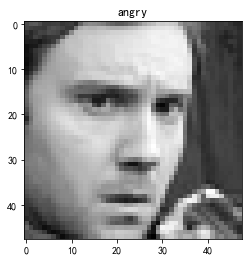

In [5]:
emotion_1,img_1,usage_1 = lines[1].split(',')
val_1 = img_1.split(' ')
pixels_1 = np.array(val_1,'float32')
aa = pixels_1.reshape(2304,1)
img = aa.reshape(int(2304**0.5),int(2304**0.5))
plt.imshow(img,plt.cm.gray)
plt.title(emotions[int(emotion_1)])

In [6]:
num_of_instances = lines.size
x_train,y_train,x_test,y_test = [],[],[],[]

for i in range(1,num_of_instances):
    try:
        emotion,img,usage = lines[i].split(',')
        val = img.split(' ')
        pixels = np.array(val,'float32')
        emotion = keras.utils.to_categorical(emotion,num_classes)
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print('',end='')

In [7]:
##数据预处理以及标准化
x_train = np.array(x_train,dtype='float32')
x_test = np.array(x_test,dtype='float32')
y_train = np.array(y_train,dtype='float32')
y_test = np.array(y_test,dtype='float32')
x_train = x_train/255
x_test = x_test/255
x_train.shape,x_test.shape

((28709, 2304), (3589, 2304))

In [8]:
##看一下训练以及测试数量
x_train = x_train.reshape(len(x_train),48,48,1)
x_test = x_test.reshape(len(x_test),48,48,1)
print('num of train:',len(x_train))
print('num of test',len(x_test))

num of train: 28709
num of test 3589


## （1）数据不变，模型调整，测试效果

因为对模型进行了调整，因此原文件的h5文件不可再次加载，因此训练轮数以及时间都稍微长一点

In [58]:
## 构造模型
from keras.callbacks import EarlyStopping,ModelCheckpoint
def build_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
    model.add(Dropout(0.5))
    


    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [59]:
model = build_model()
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
es = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=10,mode='auto')
md = ModelCheckpoint('表情监测one_new.h5',save_best_only=True)
callbacks = [es,md]


In [60]:
history = model.fit(x_train,y_train,epochs=2000,validation_split=0.1,shuffle=True,verbose=1,callbacks=callbacks)

Train on 25838 samples, validate on 2871 samples
Epoch 1/2000
25838/25838 [==============================] - 13s 521us/step - loss: 2.4185 - acc: 0.2291 - val_loss: 2.0584 - val_acc: 0.2741
Epoch 2/2000
25838/25838 [==============================] - 9s 359us/step - loss: 1.7993 - acc: 0.2508 - val_loss: 2.0763 - val_acc: 0.2776
Epoch 3/2000
25838/25838 [==============================] - 9s 352us/step - loss: 1.7796 - acc: 0.2589 - val_loss: 1.9905 - val_acc: 0.2929
Epoch 4/2000
25838/25838 [==============================] - 9s 346us/step - loss: 1.7569 - acc: 0.2771 - val_loss: 1.9765 - val_acc: 0.3079
Epoch 5/2000
25838/25838 [==============================] - 9s 350us/step - loss: 1.7167 - acc: 0.2937 - val_loss: 1.8669 - val_acc: 0.3480
Epoch 6/2000
25838/25838 [==============================] - 9s 352us/step - loss: 1.6766 - acc: 0.3270 - val_loss: 1.7958 - val_acc: 0.3786
Epoch 7/2000
25838/25838 [==============================] - 9s 353us/step - loss: 1.6437 - acc: 0.3450 - val_l

Epoch 59/2000
25838/25838 [==============================] - 9s 351us/step - loss: 1.1185 - acc: 0.5722 - val_loss: 1.2199 - val_acc: 0.5886
Epoch 60/2000
25838/25838 [==============================] - 9s 352us/step - loss: 1.1157 - acc: 0.5775 - val_loss: 1.3029 - val_acc: 0.5904
Epoch 61/2000
25838/25838 [==============================] - 9s 349us/step - loss: 1.1114 - acc: 0.5803 - val_loss: 1.3104 - val_acc: 0.5848
Epoch 62/2000
25838/25838 [==============================] - 9s 353us/step - loss: 1.0981 - acc: 0.5809 - val_loss: 1.2329 - val_acc: 0.5907
Epoch 63/2000
25838/25838 [==============================] - 9s 351us/step - loss: 1.0984 - acc: 0.5831 - val_loss: 1.1614 - val_acc: 0.5987
Epoch 64/2000
25838/25838 [==============================] - 9s 354us/step - loss: 1.0886 - acc: 0.5855 - val_loss: 1.1810 - val_acc: 0.6057
Epoch 65/2000
25838/25838 [==============================] - 9s 350us/step - loss: 1.0762 - acc: 0.5892 - val_loss: 1.2140 - val_acc: 0.5946
Epoch 66/2000

In [63]:
## 提升有望，再训练一会~~~ 
history_new = model.fit(x_train,y_train,epochs=2000,validation_split=0.1,shuffle=True,verbose=1,callbacks=callbacks)

Train on 25838 samples, validate on 2871 samples
Epoch 1/2000
25838/25838 [==============================] - 9s 357us/step - loss: 0.8899 - acc: 0.6638 - val_loss: 1.1305 - val_acc: 0.6308
Epoch 2/2000
25838/25838 [==============================] - 9s 355us/step - loss: 0.8864 - acc: 0.6686 - val_loss: 1.1550 - val_acc: 0.6364
Epoch 3/2000
25838/25838 [==============================] - 9s 359us/step - loss: 0.8845 - acc: 0.6657 - val_loss: 1.0904 - val_acc: 0.6444
Epoch 4/2000
25838/25838 [==============================] - 9s 353us/step - loss: 0.8789 - acc: 0.6703 - val_loss: 1.1177 - val_acc: 0.6392
Epoch 5/2000
25838/25838 [==============================] - 9s 350us/step - loss: 0.8848 - acc: 0.6665 - val_loss: 1.1203 - val_acc: 0.6378
Epoch 6/2000
25838/25838 [==============================] - 9s 358us/step - loss: 0.8634 - acc: 0.6727 - val_loss: 1.0773 - val_acc: 0.6419
Epoch 7/2000
25838/25838 [==============================] - 9s 355us/step - loss: 0.8754 - acc: 0.6737 - val_lo

In [67]:
## 提升有望，再训练一会~~~ 
model.fit(x_train,y_train,epochs=2000,validation_split=0.1,shuffle=True,verbose=1,callbacks=callbacks)

Train on 25838 samples, validate on 2871 samples
Epoch 1/2000
25838/25838 [==============================] - 9s 354us/step - loss: 0.7549 - acc: 0.7207 - val_loss: 1.1492 - val_acc: 0.6513
Epoch 2/2000
25838/25838 [==============================] - 9s 349us/step - loss: 0.7469 - acc: 0.7221 - val_loss: 1.2045 - val_acc: 0.6569
Epoch 3/2000
25838/25838 [==============================] - 9s 348us/step - loss: 0.7499 - acc: 0.7224 - val_loss: 1.1659 - val_acc: 0.6590
Epoch 4/2000
25838/25838 [==============================] - 9s 358us/step - loss: 0.7444 - acc: 0.7229 - val_loss: 1.1353 - val_acc: 0.6562
Epoch 5/2000
25838/25838 [==============================] - 9s 350us/step - loss: 0.7364 - acc: 0.7266 - val_loss: 1.2910 - val_acc: 0.6419
Epoch 6/2000
25838/25838 [==============================] - 9s 357us/step - loss: 0.7505 - acc: 0.7193 - val_loss: 1.1044 - val_acc: 0.6520
Epoch 7/2000
25838/25838 [==============================] - 9s 349us/step - loss: 0.7431 - acc: 0.7236 - val_lo

Text(0,0.5,'Acc')

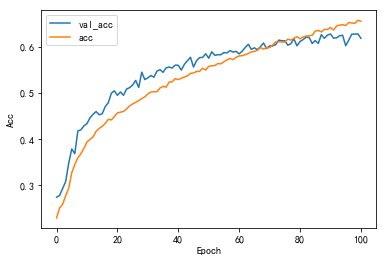

In [65]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['val_acc','acc'])
plt.xlabel('Epoch',fontsize=10)
plt.ylabel('Acc',fontsize=10)

In [68]:
y_pred = model.predict(x_test)
from sklearn.metrics import accuracy_score
print('在PublicTest上的准确率为:{}%'.format(accuracy_score(y_pred.argmax(axis=1),y_test.argmax(axis=1))*100))

在PublicTest上的准确率为:62.775146280300916%


####  =========================
比原模型要好一点点

## （2）数据集增广，模型不变，测试效果

Text(0.5,1,'旋转')

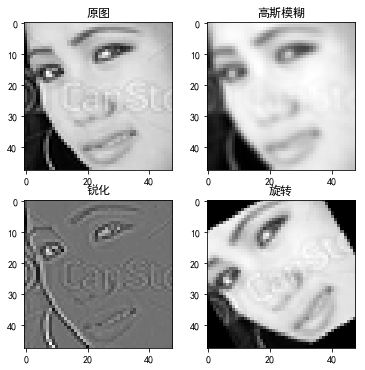

In [69]:
## 看一下增广数据集的效果
plt.figure(figsize=(6,6))
img_test = x_test[1]

plt.subplot(2,2,1)
plt.imshow(img_test.reshape(48,48),plt.cm.gray)
plt.title('原图')

plt.subplot(2,2,2)
img_gauss = cv2.GaussianBlur(img_test,(3,3),1)
plt.imshow(img_gauss,plt.cm.gray)
plt.title('高斯模糊')

plt.subplot(2,2,3)
kernel = np.array([[0,-0.5,0],[-1,3,-1],[0,-0.5,0]],np.float32)
img_ruihua = cv2.filter2D(img_test,-1,kernel)
plt.imshow(img_ruihua,plt.cm.gray)
plt.title('锐化')

plt.subplot(2,2,4)
xuanzhuan = cv2.getRotationMatrix2D((24,24),30,1)
img_xuanzhuan = cv2.warpAffine(img_test,xuanzhuan,(48,48))
plt.imshow(img_xuanzhuan,plt.cm.gray)
plt.title('旋转')
    


In [70]:
def build_model_zero():
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model


model_zero = build_model_zero()
model_zero.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model_zero.load_weights('./model/facial_expression_model_weights.h5')

In [71]:
## 扩增数据集
x_gauss = np.empty((len(x_train),48,48),dtype='float32')
x_ruihua = np.empty((len(x_train),48,48),dtype='float32')
x_xuanzhuan = np.empty((len(x_train),48,48),dtype='float32')

for i in range(len(x_train)):
    img = x_train[i]
    ##高斯模糊
    img_gauss = cv2.GaussianBlur(img,(3,3),0)
    x_gauss[i] = img_gauss
    
    ##图形锐化
    kernel = np.array([[0,-0.5,0],[-1,3,-1],[0,-0.5,0]],np.float32)
    img_ruihua = cv2.filter2D(img,-1,kernel)
    x_ruihua[i] = img_ruihua
    
    ##图像旋转
    jiaodu = np.random.randint(0,180)
    xuanzhuan = cv2.getRotationMatrix2D((24,24),jiaodu,1)
    img_xuanzhuan = cv2.warpAffine(img,xuanzhuan,(48,48))
    x_xuanzhuan[i] = img_xuanzhuan
    
##扩增数据集
y_train_new = np.concatenate((y_train,y_train,y_train,y_train))
x_train_new = np.concatenate((x_train,x_gauss.reshape(len(x_gauss),48,48,1),x_ruihua.reshape(len(x_gauss),48,48,1),x_xuanzhuan.reshape(len(x_gauss),48,48,1)))
y_train_new.shape,x_train_new.shape

((114836, 7), (114836, 48, 48, 1))

In [72]:
es = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=10,mode='auto')
md = ModelCheckpoint('表情监测数据.h5',save_best_only=True)
callbacks = [es,md]
model_zero.fit(x_train_new,y_train_new,epochs=2000,validation_split=0.1,callbacks=callbacks,verbose=1,shuffle=True)

Train on 103352 samples, validate on 11484 samples
Epoch 1/2000
103352/103352 [==============================] - 30s 286us/step - loss: 1.2252 - acc: 0.5458 - val_loss: 1.6916 - val_acc: 0.3252
Epoch 2/2000
103352/103352 [==============================] - 25s 243us/step - loss: 1.1190 - acc: 0.5779 - val_loss: 1.6746 - val_acc: 0.3400
Epoch 3/2000
103352/103352 [==============================] - 25s 242us/step - loss: 1.0684 - acc: 0.5974 - val_loss: 1.6779 - val_acc: 0.3643
Epoch 4/2000
103352/103352 [==============================] - 25s 241us/step - loss: 1.0188 - acc: 0.6165 - val_loss: 1.6410 - val_acc: 0.3689
Epoch 5/2000
103352/103352 [==============================] - 25s 242us/step - loss: 0.9723 - acc: 0.6353 - val_loss: 1.6672 - val_acc: 0.3750
Epoch 6/2000
103352/103352 [==============================] - 25s 243us/step - loss: 0.9283 - acc: 0.6513 - val_loss: 1.6110 - val_acc: 0.3760
Epoch 7/2000
103352/103352 [==============================] - 25s 243us/step - loss: 0.8853

In [73]:
y_pred = model_zero.predict(x_test)
from sklearn.metrics import accuracy_score
print('在PublicTest上的准确率为:{}%'.format(accuracy_score(y_pred.argmax(axis=1),y_test.argmax(axis=1))*100))

在PublicTest上的准确率为:57.00752298690443%


这个准确率提升的实在有限，那再换一下，说明单纯的做数据增广不太行，再加上模型优化

## （3）数据集增广，模型调整，测试效果

In [74]:
model_shumo = build_model()
model_shumo.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
es = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=10,mode='auto')
md = ModelCheckpoint('表情监测shumo.h5',save_best_only=True)
callbacks = [es,md]
model_shumo.fit(x_train_new,y_train_new,epochs=2000,validation_split=0.1,callbacks=callbacks,verbose=1,shuffle=True)

Train on 103352 samples, validate on 11484 samples
Epoch 1/2000
103352/103352 [==============================] - 42s 403us/step - loss: 1.9825 - acc: 0.2394 - val_loss: 3.0874 - val_acc: 0.2542
Epoch 2/2000
103352/103352 [==============================] - 37s 356us/step - loss: 1.7804 - acc: 0.2610 - val_loss: 3.2626 - val_acc: 0.2524
Epoch 3/2000
103352/103352 [==============================] - 36s 352us/step - loss: 1.7362 - acc: 0.2897 - val_loss: 4.0042 - val_acc: 0.2025
Epoch 4/2000
103352/103352 [==============================] - 36s 350us/step - loss: 1.6912 - acc: 0.3156 - val_loss: 2.3133 - val_acc: 0.2597
Epoch 5/2000
103352/103352 [==============================] - 36s 349us/step - loss: 1.6497 - acc: 0.3377 - val_loss: 2.7313 - val_acc: 0.2524
Epoch 6/2000
103352/103352 [==============================] - 36s 353us/step - loss: 1.6101 - acc: 0.3594 - val_loss: 2.0529 - val_acc: 0.2659
Epoch 7/2000
103352/103352 [==============================] - 37s 354us/step - loss: 1.5766

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



103352/103352 [==============================] - 36s 351us/step - loss: 0.9355 - acc: 0.6486 - val_loss: 1.2662 - val_acc: 0.5238
Epoch 81/2000
103352/103352 [==============================] - 37s 354us/step - loss: 0.9295 - acc: 0.6498 - val_loss: 1.2538 - val_acc: 0.5224
Epoch 82/2000
103352/103352 [==============================] - 36s 352us/step - loss: 0.9306 - acc: 0.6483 - val_loss: 1.2662 - val_acc: 0.5229
Epoch 83/2000
103352/103352 [==============================] - 36s 350us/step - loss: 0.9288 - acc: 0.6502 - val_loss: 1.2663 - val_acc: 0.5193
Epoch 84/2000
 65120/103352 [=================>............] - ETA: 12s - loss: 0.9247 - acc: 0.6507

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



103352/103352 [==============================] - 37s 359us/step - loss: 0.9102 - acc: 0.6572 - val_loss: 1.2559 - val_acc: 0.5235
Epoch 91/2000
103352/103352 [==============================] - 36s 351us/step - loss: 0.9072 - acc: 0.6595 - val_loss: 1.2712 - val_acc: 0.5246
Epoch 92/2000
103352/103352 [==============================] - 36s 351us/step - loss: 0.9025 - acc: 0.6631 - val_loss: 1.2569 - val_acc: 0.5274
Epoch 93/2000
103352/103352 [==============================] - 36s 350us/step - loss: 0.9057 - acc: 0.6596 - val_loss: 1.2681 - val_acc: 0.5242
Epoch 94/2000
103352/103352 [==============================] - 36s 351us/step - loss: 0.8990 - acc: 0.6628 - val_loss: 1.2455 - val_acc: 0.5279


In [75]:
y_pred = model_shumo.predict(x_test)
from sklearn.metrics import accuracy_score
print('在PublicTest上的准确率为:{}%'.format(accuracy_score(y_pred.argmax(axis=1),y_test.argmax(axis=1))*100))

在PublicTest上的准确率为:65.8400668709947%


### 虽然在验证集上准确率不高，但是分类器比较强，所以在PublicTest上面有着意外的惊喜